# Morphology Feature Extraction
First we load all the data and names:

In [1]:
from skimage import io
import os
import numpy as np
import organoid_prediction_python as opp
import pandas as pd

# needs to be changed to repository directory
home_directory = r"C:\Users\savill\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation/"
folder_masks = home_directory + r"image_data\Processed Data\Masks Brightfield\72h"
folder_bf = home_directory + r"image_data\Processed Data\Focussed Images\72h\Brightfield"
folder_bra = home_directory + r"image_data\Processed Data\Focussed Images\72h\Brachyury"

bf_collection = io.imread_collection(folder_bf+"/*.tif")
file_names_bf = [os.path.split(fname)[1] for fname in bf_collection.files]

mask_collection = io.imread_collection(folder_masks+"/*.tif")
file_names_mask = [os.path.split(fname)[1] for fname in mask_collection.files]

bra_collection = io.imread_collection(folder_bra+"/*.tif")
file_names_bra = [os.path.split(fname)[1] for fname in bra_collection.files]

## Simple Morphology
Here we calculate the basic morphology features using the normal masks:

In [2]:
dfs = []
for mask, img in zip(mask_collection,bf_collection):
        dfs.append(pd.DataFrame(opp.simple_brightfield_regionprops(mask,img)))
    
df =  pd.concat(dfs,axis =0,ignore_index=True)

pixel_size = 2.7493
length_columns = ["axis","perimeter","diameter"]
for column in df.columns:
    if any([length in column for length in length_columns]):
        df[column] = df[column].to_numpy() * pixel_size
    if ("area" in column) and ("fraction" not in column): 
        df[column] = df[column].to_numpy() * (pixel_size**2)

sample_identifier = opp.extract_sample_identifiers(file_names_bf)
output_dataframe = pd.concat([sample_identifier.drop("Filename",axis=1),df],axis=1)
output_dataframe.set_index(["Run","Plate","ID"],inplace=True)
output_dataframe

area    perimeter  axis_major_length   
Run Plate ID                                                  
RR  1     A1   74513.176530  1022.988147         314.867941  \
          A2   60265.120357   917.066108         284.440747   
          A3   75095.192618  1037.206352         328.776089   
          A4   63598.485223   954.060260         298.476242   
          A5   66697.531924   966.667963         305.139746   
...                     ...          ...                ...   
TR  2     H8   65858.521719   959.444406         297.895025   
          H9   59085.970880   906.068908         275.738932   
          H10  67604.569983   984.497947         301.327300   
          H11  53175.106197   859.135421         263.562738   
          H12  61550.090940   922.288390         284.624284   

               axis_minor_length  eccentricity  feret_diameter_max  solidity   
Run Plate ID                                                                   
RR  1     A1          301.770504      0.285417          324.708509  0.987875  \
          A2          270.559105      0.308585          292.306321  0.987002   
          A3          291.812218      0.460670          340.258504  0.985029   
          A4          271.821410      0.413075          302.735259  0.985939   
          A5          278.708786      0.407106          311.484892  0.986804   
...                          ...           ...                 ...       ...   
TR  2     H8          281.965729      0.322624          309.586318  0.985745   
          H9          272.966099      0.141460          282.014398  0.987868   
          H10         286.375543      0.311090          310.135176  0.986108   
          H11         257.054078      0.220862          270.173810  0.988339   
          H12         275.484891      0.251376          290.607643  0.987988   

               aspect_ratio  
Run Plate ID                 
RR  1     A1       0.958403  
          A2       0.951197  
          A3       0.887571  
          A4       0.910697  
          A5       0.913381  
...                     ...  
TR  2     H8       0.946527  
          H9       0.989944  
          H10      0.950380  
          H11      0.975305  
          H12      0.967890  

[672 rows x 8 columns]

Saving the table

In [3]:
output_location = home_directory + r"tabular_data\72h"

if not os.path.exists(output_location):
   os.makedirs(output_location)
   print("The new directory is created!")

output_dataframe.to_csv(f"{output_location}/simple_shape_features_72h.csv")

## Straight Morphology
Complex morphology is calculated using the straightened masks as implemented in MOrgAna. First we'll test the straightening and then do the analysis:

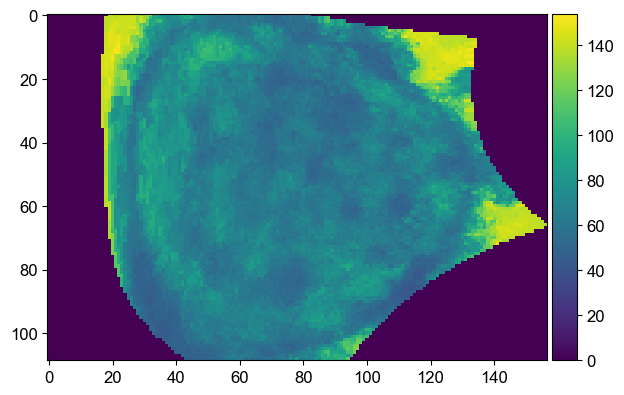

In [4]:
idx = 12
ma_test, bf_test = opp.straighten_mask_and_image(mask_collection[idx],bf_collection[idx])
io.imshow(bf_test)

In [5]:
%%time

straight_masks = []
straight_bra = []

for mask, img in zip(mask_collection,bra_collection):
    ma_straight, bra_straight = opp.straighten_mask_and_image(mask,img)
    straight_masks.append(ma_straight)
    straight_bra.append(bra_straight)
    
straight_morgana_features = opp.calculate_morgana_shapes(straight_masks,mask_collection.files)
straight_morgana_features

CPU times: total: 17min 7s
Wall time: 17min 56s


,area,eccentricity,major_axis_length,minor_axis_length,equivalent_diameter,perimeter,extent,orientation,form_factor,input_file,...,locoefa_coeff_42,locoefa_coeff_43,locoefa_coeff_44,locoefa_coeff_45,locoefa_coeff_46,locoefa_coeff_47,locoefa_coeff_48,locoefa_coeff_49,locoefa_coeff_50,locoefa_coeff_51
0,9907,0.294,115.206166,110.114668,112.311995,397.031529,0.749338,0.610486,1.266187,result_segmentation\FK223_run_RR_PLATE_1_ID_A1...,...,0.049468,0.043649,0.060994,0.012201,0.044493,0.018447,0.040926,0.024938,0.051221,0.0
1,7954,0.328263,103.932263,98.173008,100.634722,349.261977,0.765176,-0.138425,1.220414,result_segmentation\FK223_run_RR_PLATE_1_ID_A2...,...,0.038156,0.028135,0.024879,0.019871,0.066128,0.006545,0.036038,0.025326,0.018152,0.0
2,9819,0.441055,118.237606,106.115907,111.81207,399.445743,0.743864,-0.227067,1.293119,result_segmentation\FK223_run_RR_PLATE_1_ID_A3...,...,0.013494,0.047434,0.010465,0.005077,0.072005,0.009359,0.045763,0.012756,0.001864,0.0
3,8275,0.379395,106.823071,98.836443,102.645298,365.717821,0.781176,-0.090836,1.286217,result_segmentation\FK223_run_RR_PLATE_1_ID_A4...,...,0.054771,0.037017,0.058074,0.081701,0.052206,0.010058,0.030055,0.038963,0.028982,0.0
4,8996,0.439474,113.462703,101.918461,107.023656,378.47518,0.759477,-0.179394,1.267113,result_segmentation\FK223_run_RR_PLATE_1_ID_A5...,...,0.046483,0.0858,0.053996,0.076884,0.031099,0.016929,0.041184,0.018271,0.007316,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,8713,0.322624,108.353044,102.559098,105.326806,348.977705,0.798772,-0.012035,1.112289,result_segmentation\FK223_run_TR_PLATE_2_ID_H8...,...,0.024117,0.018177,0.045584,0.016795,0.057017,0.010776,0.0235,0.001575,0.017716,0.0
668,7807,0.147091,100.273147,99.182469,99.700457,334.63456,0.780778,0.070041,1.141425,result_segmentation\FK223_run_TR_PLATE_2_ID_H9...,...,0.041215,0.029979,0.071291,0.053533,0.03617,0.04765,0.040327,0.014779,0.01075,0.0
669,8817,0.267638,108.092245,104.149003,105.953542,374.688384,0.770178,0.154722,1.267097,result_segmentation\FK223_run_TR_PLATE_2_ID_H1...,...,0.063338,0.037611,0.044897,0.011219,0.080646,0.013418,0.05196,0.002942,0.027978,0.0
670,6916,0.253735,95.450322,92.326585,93.838823,327.788889,0.758333,-1.109836,1.236299,result_segmentation\FK223_run_TR_PLATE_2_ID_H1...,...,0.026691,0.062857,0.049758,0.012595,0.048077,0.026023,0.040223,0.031366,0.009639,0.0


In [6]:
df = straight_morgana_features

pixel_size = 2.7493
length_columns = ["axis","perimeter","diameter"]
for column in df.columns:
    if any([length in column for length in length_columns]):
        df[column] = df[column].to_numpy() * pixel_size
    if ("area" in column) and ("fraction" not in column): 
        df[column] = df[column].to_numpy() * (pixel_size**2)
        
sample_identifier = opp.extract_sample_identifiers(file_names_bf)
output_dataframe = pd.concat([sample_identifier.drop("Filename",axis=1),df.drop("input_file",axis=1)],axis=1)
output_dataframe.set_index(["Run","Plate","ID"],inplace=True)
output_dataframe

area eccentricity major_axis_length minor_axis_length   
Run Plate ID                                                                   
RR  1     A1   74883.550404        0.294        316.736311        302.738257  \
          A2   60121.505997     0.328263         285.74097        269.907051   
          A3   74218.389161     0.441055        325.070651        291.744464   
          A4   62547.832805     0.379395        293.688669        271.731034   
          A5   67997.619808     0.439474        311.943008        280.204426   
...                     ...          ...               ...               ...   
TR  2     H8   65858.521719     0.322624        297.895025        281.965729   
          H9   59010.384375     0.147091        275.680963        272.682362   
          H10   66644.62137     0.267638         297.17801        286.336853   
          H11  52275.626789     0.253735        262.421572        253.833479   
          H12  60756.432639     0.208454        281.345164        275.164634   

              equivalent_diameter    perimeter    extent orientation   
Run Plate ID                                                           
RR  1     A1           308.779367  1091.558783  0.749338    0.610486  \
          A2           276.675042   960.225952  0.765176   -0.138425   
          A3           307.404925  1098.196181  0.743864   -0.227067   
          A4           282.202718  1005.468005  0.781176   -0.090836   
          A5           294.240137  1040.541813  0.759477   -0.179394   
...                           ...          ...       ...         ...   
TR  2     H8           289.574989   959.444406  0.798772   -0.012035   
          H9           274.106466   920.010795  0.780778    0.070041   
          H10          291.298073  1030.130773  0.770178    0.154722   
          H11          257.991076   901.189991  0.758333   -1.109836   
          H12           278.13215   979.895349  0.765087   -0.335812   

              form_factor aspect_ratio  ... locoefa_coeff_42 locoefa_coeff_43   
Run Plate ID                            ...                                     
RR  1     A1     1.266187     1.046238  ...         0.049468         0.043649  \
          A2     1.220414     1.058664  ...         0.038156         0.028135   
          A3     1.293119     1.114231  ...         0.013494         0.047434   
          A4     1.286217     1.080807  ...         0.054771         0.037017   
          A5     1.267113     1.113269  ...         0.046483           0.0858   
...                   ...          ...  ...              ...              ...   
TR  2     H8     1.112289     1.056494  ...         0.024117         0.018177   
          H9     1.141425     1.010997  ...         0.041215         0.029979   
          H10    1.267097     1.037862  ...         0.063338         0.037611   
          H11    1.236299     1.033834  ...         0.026691         0.062857   
          H12    1.257643     1.022461  ...         0.013371         0.069135   

              locoefa_coeff_44 locoefa_coeff_45 locoefa_coeff_46   
Run Plate ID                                                       
RR  1     A1          0.060994         0.012201         0.044493  \
          A2          0.024879         0.019871         0.066128   
          A3          0.010465         0.005077         0.072005   
          A4          0.058074         0.081701         0.052206   
          A5          0.053996         0.076884         0.031099   
...                        ...              ...              ...   
TR  2     H8          0.045584         0.016795         0.057017   
          H9          0.071291         0.053533          0.03617   
          H10         0.044897         0.011219         0.080646   
          H11         0.049758         0.012595         0.048077   
          H12         0.021151         0.039689         0.070688   

              locoefa_coeff_47 locoefa_coeff_48 locoefa_coeff_49   
Run Plate ID                          

Now we calculate the extent of polarisation of the brachyury signal using the straightened mask and straightened brachyury signal:

In [7]:
polarisation_props = opp.measure_brachyury_polarisation(straight_bra,straight_masks,file_names_bra)
sample_identifier = opp.extract_sample_identifiers(polarisation_props["filenames"])
df_polarisation = pd.concat([sample_identifier.drop("Filename",axis=1),polarisation_props.drop("filenames",axis=1)],axis=1)
df_polarisation.set_index(["Run","Plate","ID"],inplace=True)

df_polarisation

first_axis_polarisation  second_axis_polarisation
Run Plate ID                                                    
RR  1     A1                  0.034712                  0.004817
          A2                  0.033152                  0.000424
          A3                  0.010328                  0.004771
          A4                  0.012553                  0.014943
          A5                  0.017524                  0.001071
...                                ...                       ...
TR  2     H8                  0.003453                  0.000982
          H9                  0.023644                  0.001422
          H10                 0.027352                  0.006202
          H11                 0.011360                  0.017500
          H12                 0.000110                  0.001110

[672 rows x 2 columns]

Now we save the combined dataframe:

In [8]:
output_location = home_directory + r"tabular_data\72h"

if not os.path.exists(output_location):
   os.makedirs(output_location)
   print("The new directory is created!")

output_dataframe.to_csv(f"{output_location}/straight_morgana_shape_features_72h.csv")
df_polarisation.to_csv(f"{output_location}/straight_morgana_brachyury_polarisation_72h.csv")